In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [2]:
def res_block(ip):
    res_model = Conv2D(64,(3,3), padding='same')(ip)
    res_model = BatchNormalization(momentum=0.5)(res_model)
    res_model = PReLU(shared_axes=[1,2])(res_model)

    res_model = Conv2D(64,(3,3),padding= 'same')(res_model)
    res_model = BatchNormalization(momentum=0.5)(res_model)

    return add([ip,res_model])

In [3]:
def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding='same')(ip)
    up_model = UpSampling2D(size=2)(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

In [4]:
###Generator Model

def create_gen(gen_ip, num_res_block):

    layers = Conv2D(64, (9,9), padding= 'same')(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding='same')(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([temp, layers])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding='same')(layers)

    return Model(inputs = gen_ip, outputs=op)


In [5]:
## Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    disc_model = Conv2D(filters, (3,3), strides = strides, padding='same')(ip)

    if bn:
        disc_model = BatchNormalization(momentum=0.8)(disc_model)

    disc_model = LeakyReLU(alpha=0.2)(disc_model)

    return disc_model

In [6]:
# descriminator model
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip,df,bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides = 2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [7]:
from keras.applications import VGG19

In [8]:
def build_vgg(hr_shape):
    vgg = VGG19(weights = 'imagenet', include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [9]:
# combined model
def create_combo(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [10]:
n=2000
lr_list = os.listdir(r"C:\Users\saivi\Desktop\GANs_Corsera\SRGAN\lr_images")[:n]

lr_images = []

for img in lr_list:
    img_lr = cv2.imread(r"C:\\Users\\saivi\\Desktop\\GANs_Corsera\\SRGAN\\lr_images\\" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)

In [11]:
hr_list = os.listdir(r"C:\\Users\\saivi\\Desktop\\GANs_Corsera\\SRGAN\\hr_images")[:n]

hr_images = []
for img in hr_list:
    img_hr = cv2.imread(r"C:\\Users\\saivi\\Desktop\\GANs_Corsera\\SRGAN\\hr_images\\" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

In [12]:
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

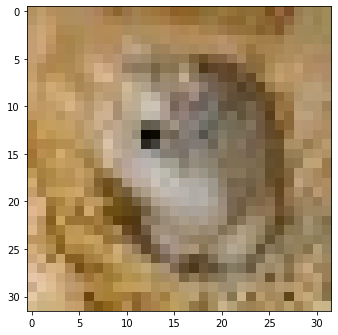

In [13]:
# sanity check, view few images
import random
import numpy as np

image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number],(32,32,3)))

plt.show()

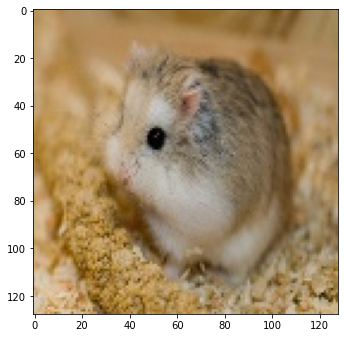

In [14]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(hr_images[image_number], (128, 128,3)))
plt.show()

In [15]:
# Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.


In [16]:
# split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.33,
                                                        random_state=42)

In [17]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

In [18]:
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)


In [19]:
generator = create_gen(lr_ip, num_res_block=16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [20]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [21]:
vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [22]:
gan_model = create_combo(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=['binary_crossentropy','mse'], loss_weights=[1e-3, 1], optimizer='adam')
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [23]:
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [24]:
epochs = 5
for e in tqdm(range(epochs)):
    fake_label = np.zeros((batch_size,1))
    real_label = np.ones((batch_size,1))
    #empty list to populate gen and disc losses
    g_losses = []
    d_losses = []

    # enumerate training over batches
    for b in range(len(train_hr_batches)):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]

        fake_imgs = generator.predict_on_batch(lr_imgs)

        # First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purpose
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)

        #train the generator via GAN
        g_loss,_,_ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        # save losses to a list so we can average and report
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    #Convert list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    # report the progress during training
    print("epoch:" , e+1, "g_loss:", g_loss, "d_loss:",d_loss)




  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


In [ ]:
e

2

In [ ]:
generator.save("gen_e1_1k_imgs.h5")

In [ ]:
## Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

In [ ]:
generator = load_model('gen_e1_1k_imgs.h5', compile = False)


In [ ]:
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


1/1 [==============================] - 0s 128ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


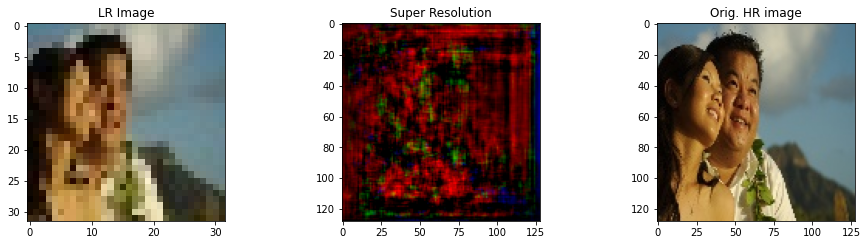

In [ ]:
#plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Super Resolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()